<a href="https://colab.research.google.com/github/Eswari-21/Car-Detection-using-AI/blob/main/workshop_day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ultralytics opencv-python matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 883.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00


In [3]:
# ⚙️ Cell 2 – Imports & helper functions
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO          # YOLOv8
from google.colab import files
from tqdm import tqdm
import shutil, tempfile, os, sys, time

# ---------- Model ---------- #
def load_model(weights: str = "yolov8n.pt") -> YOLO:
    """Load and fuse a YOLOv8 model."""
    model = YOLO(weights)
    model.fuse()
    return model

# ---------- Detection ---------- #
def detect_cars(img_bgr, model, conf_thres=0.25):
    """Return list of car detections in xyxy format with confidence."""
    results = model(img_bgr, verbose=False, conf=conf_thres)[0]
    car_ids = [cls_id for cls_id, name in model.names.items() if name == "car"]
    dets = []
    for box in results.boxes:
        if int(box.cls) in car_ids:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            dets.append({"xyxy": (x1, y1, x2, y2), "conf": float(box.conf)})
    return dets

# ---------- Drawing ---------- #
def draw_boxes(img_bgr, detections, color=(0,255,255)):
    """Draw yellow boxes + confidences on the image (in place)."""
    for det in detections:
        x1,y1,x2,y2 = det["xyxy"]
        conf        = det["conf"]
        cv2.rectangle(img_bgr,(x1,y1),(x2,y2),color,2)
        label = f"car {conf:.2f}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX,0.6,2)
        cv2.rectangle(img_bgr,(x1,y1-th-4),(x1+tw+4,y1),color,-1)
        cv2.putText(img_bgr,label,(x1+2,y1-2),cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,(0,0,0),2,cv2.LINE_AA)

# ---------- Image pipeline ---------- #
def process_image(path_in, path_out, model, conf=0.25):
    img = cv2.imread(str(path_in))
    if img is None:
        raise FileNotFoundError(path_in)
    dets = detect_cars(img, model, conf)
    draw_boxes(img, dets)
    cv2.imwrite(str(path_out), img)
    print(f"✅ Saved: {path_out}  |  cars found: {len(dets)}")
    # display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6)); plt.axis("off"); plt.imshow(img_rgb); plt.show()

# ---------- Video pipeline ---------- #
def process_video(path_in, path_out, model, conf=0.25):
    cap = cv2.VideoCapture(str(path_in))
    if not cap.isOpened(): raise FileNotFoundError(path_in)
    fps   = cap.get(cv2.CAP_PROP_FPS)
    w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourc = cv2.VideoWriter_fourcc(*"mp4v")
    out   = cv2.VideoWriter(str(path_out), fourc, fps, (w,h))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in tqdm(range(frames), desc="Processing video"):
        ret, frame = cap.read()
        if not ret: break
        dets = detect_cars(frame, model, conf)
        draw_boxes(frame, dets)
        out.write(frame)
    cap.release(); out.release()
    print(f"✅ Video saved to {path_out}")


100%|██████████| 6.25M/6.25M [00:00<00:00, 99.4MB/s]


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


Saving car.png to car (1).png
✅ Saved: car (1)_cars.jpg  |  cars found: 1


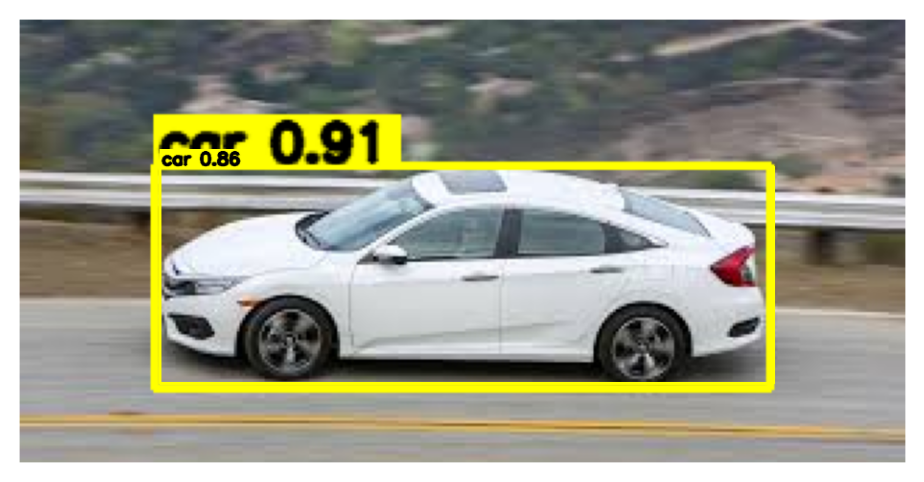

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# 📷 Cell 3 – Upload and run on an IMAGE
model = load_model("yolov8n.pt")       # or your custom weights
uploaded = files.upload()              # choose an image
for fname in uploaded.keys():
    inp  = Path(fname)
    outp = inp.stem + "_cars.jpg"
    process_image(inp, outp, model, conf=0.25)
    files.download(outp)               # download annotated image


In [6]:
# 🎞️ Cell 4 – Upload and run on a VIDEO  (optional; can be slow)
model = load_model("yolov8n.pt")
uploaded = files.upload()              # choose a .mp4/.avi
for fname in uploaded.keys():
    inp  = Path(fname)
    outp = inp.stem + "_cars.mp4"
    process_video(inp, outp, model, conf=0.25)
    files.download(outp)               # download annotated video


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


Saving cars.mp4 to cars (2).mp4


Processing video: 100%|██████████| 335/335 [01:02<00:00,  5.34it/s]

✅ Video saved to cars (2)_cars.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>